In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()


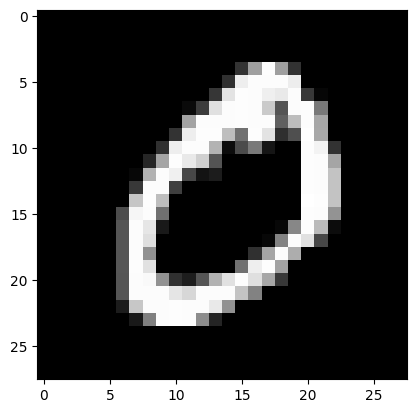

0


In [27]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='../Datasets', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='../Datasets', train=False, download=True, transform=transform)
print(train_data)
print(test_data)
image, label = train_data[1]
plt.imshow(image.reshape(28,28), cmap='gray') # image if od 3d (1,28,28) need it in (28,28)
plt.show()
print(label)

In [28]:
train_data_loader = DataLoader(train_data, batch_size=20, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=20, shuffle=True)

In [29]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(5*5*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*32) # flattens it
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [30]:
torch.manual_seed(12345)
model = ConvolutionalNetwork()
model


ConvolutionalNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_data_loader):
        b+=1

        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)

        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(20*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_data_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

epoch:  0  batch:  600 [  6000/60000]  loss: 0.20277944  accuracy:  84.758%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.06999855  accuracy:  89.971%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.08826484  accuracy:  92.147%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.03099024  accuracy:  93.423%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.08593099  accuracy:  94.245%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.00591773  accuracy:  97.667%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00725190  accuracy:  97.983%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.06829877  accuracy:  98.033%
epoch:  1  batch: 2400 [ 24000/60000]  loss: 0.01546791  accuracy:  98.058%
epoch:  1  batch: 3000 [ 30000/60000]  loss: 0.08674012  accuracy:  98.135%
epoch:  2  batch:  600 [  6000/60000]  loss: 0.00850773  accuracy:  98.683%
epoch:  2  batch: 1200 [ 12000/60000]  loss: 0.22402680  accuracy:  98.688%
epoch:  2  batch: 1800 [ 18000/60000]  loss: 0.00155855  accuracy:  98.681%
epoch:  2  b

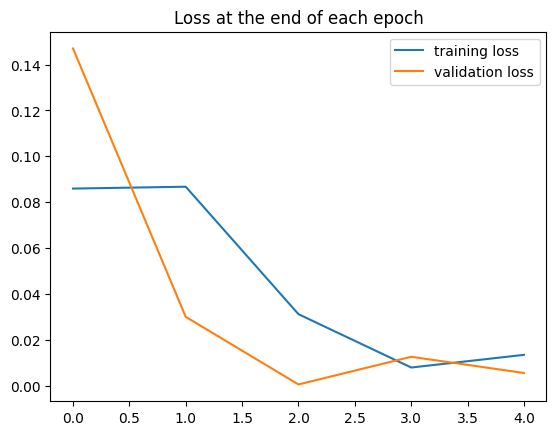

In [33]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

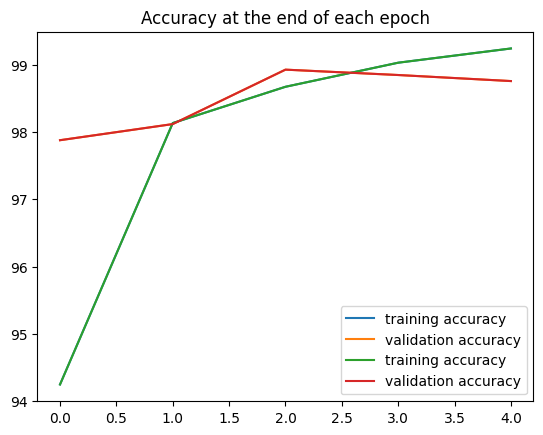

In [35]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show()